In [13]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [14]:
from app import langsmith_rag

question = "Why is climate change a big issue nowadays?"
langsmith_rag(question)


'Climate change is a significant issue today due to its widespread impact on the environment, economy, and human health. It leads to extreme weather events, rising sea levels, and loss of biodiversity, affecting food security and water supply. Additionally, the urgency of addressing climate change has increased with the recognition of its long-term consequences on future generations.'

### Creating a dataset

In [16]:
from langsmith import Client

# Example data for a climate science topic
climate_science_dataset = [
    (
        "What causes climate change?",
        """Climate change is primarily caused by greenhouse gas emissions from human activities like burning fossil fuels,
        deforestation, and industrial processes. These gases trap heat in the atmosphere.""",
        "Climate change is mainly driven by human activities that release greenhouse gases, particularly carbon dioxide and methane. When we burn fossil fuels for energy, cut down forests, and engage in industrial agriculture, these gases accumulate in the atmosphere and trap heat, leading to global warming."
    ),
    (
        "What are renewable energy sources?",
        """Renewable energy sources are natural resources that replenish themselves, including solar, wind, hydroelectric,
        geothermal, and biomass energy. They produce little to no greenhouse gas emissions.""",
        "Renewable energy comes from sources that naturally replenish, like sunlight, wind, and water. Solar panels convert sunlight to electricity, wind turbines harness air movement, and hydroelectric dams use flowing water. These clean energy sources help reduce our dependence on fossil fuels and combat climate change."
    ),
    (
        "How do oceans affect climate?",
        """Oceans play a crucial role in regulating climate by absorbing heat and carbon dioxide. Ocean currents distribute
        warmth around the globe, and marine ecosystems help maintain atmospheric balance.""",
        "Oceans act as Earth's climate regulator by absorbing about 90% of excess heat from global warming and roughly 25% of CO2 emissions. They also drive weather patterns through currents like the Gulf Stream. However, this is causing ocean acidification and warming, which threatens marine life."
    ),
    (
        "What is carbon footprint?",
        """A carbon footprint measures the total greenhouse gas emissions caused by an individual, organization, or product,
        typically expressed in tons of CO2 equivalent.""",
        "Your carbon footprint is the total amount of greenhouse gases produced by your daily activities, from driving and flying to eating and shopping. It's measured in carbon dioxide equivalents. Reducing your carbon footprint might include using public transit, eating less meat, or choosing energy-efficient appliances."
    ),
    (
        "What are the effects of deforestation?",
        """Deforestation leads to habitat loss, increased CO2 in the atmosphere, soil erosion, disrupted water cycles,
        and loss of biodiversity. Trees are vital carbon sinks that absorb greenhouse gases.""",
        "When forests are cleared, we lose important carbon-absorbing trees, which increases atmospheric CO2. Deforestation also destroys animal habitats, causes soil degradation, and disrupts local rainfall patterns. This is particularly concerning in tropical rainforests, which house most of Earth's biodiversity."
    ),
]

# Initialize LangSmith client
client = Client()

# Define a new dataset name
dataset_name = "climate_dataset"

# Create a new dataset
dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="A dataset containing questions and answers about climate change, renewable energy, and environmental science."
)

# Prepare structured data
inputs = [{"question": q, "context": c} for q, c, _ in climate_science_dataset]
outputs = [{"output": o} for _, _, o in climate_science_dataset]

# Create examples in the dataset
client.create_examples(
    inputs=inputs,
    outputs=outputs,
    dataset_id=dataset.id,
)

print(f"Dataset '{dataset_name}' created successfully with {len(climate_science_dataset)} examples!")

Dataset 'climate_dataset' created successfully with 5 examples!


In [18]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
client = Client()
prompt = client.pull_prompt("climate_bot")

### New prompt that we made can be seen here in the prompt hub

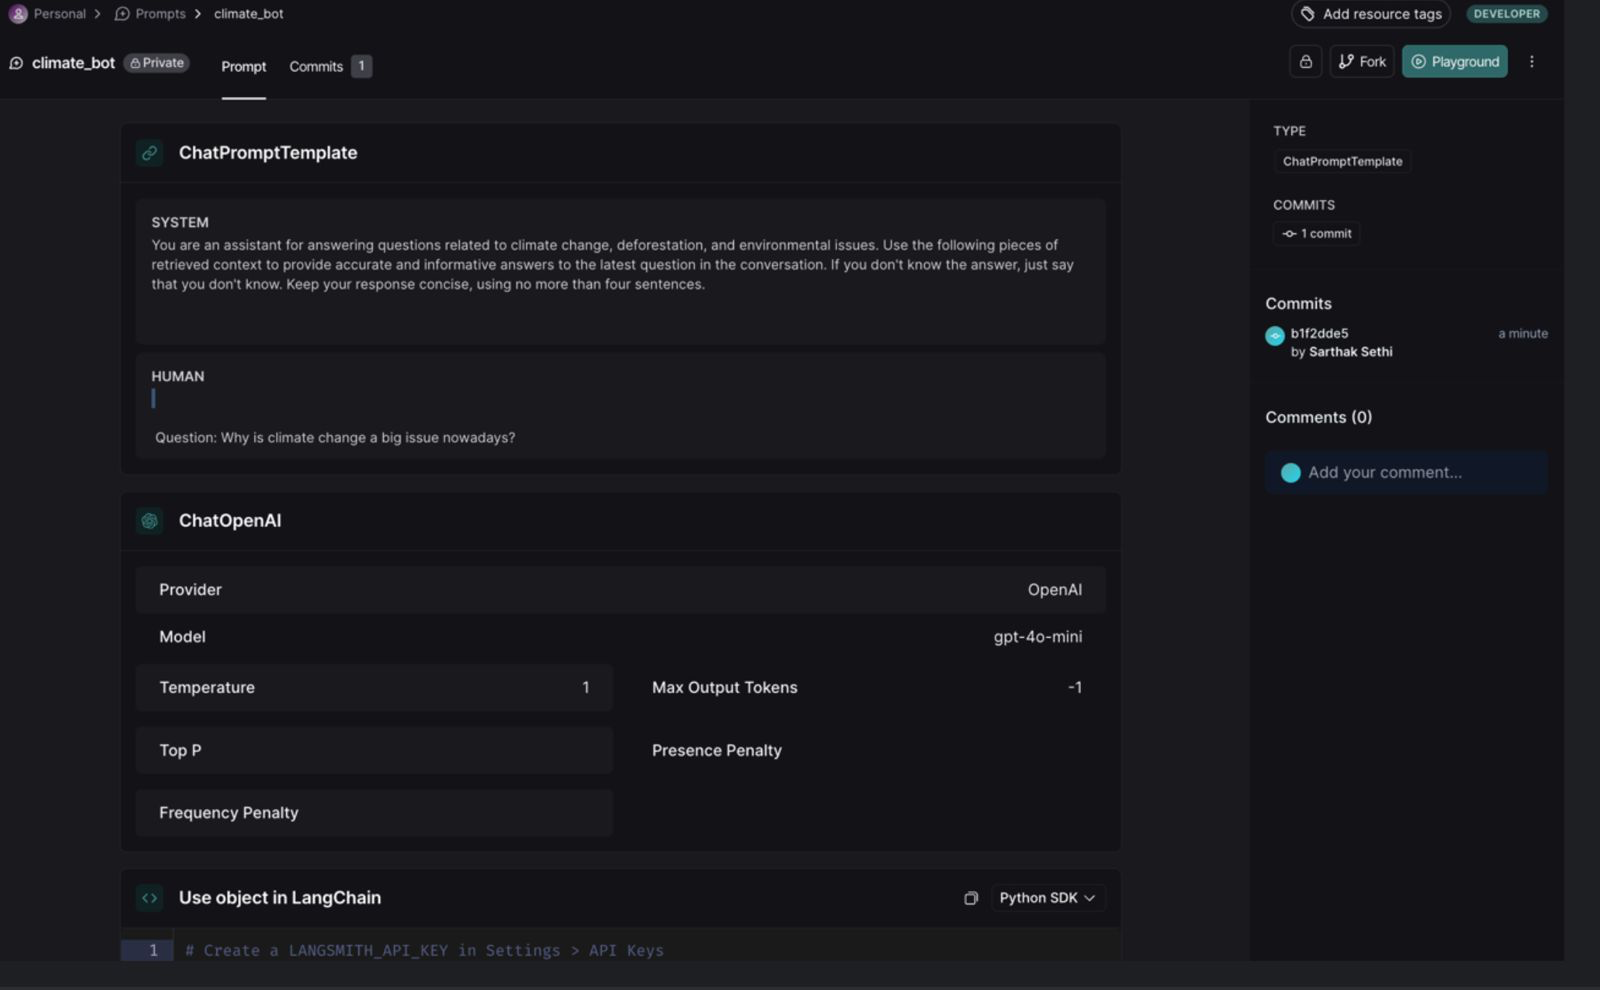


In [19]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from langsmith.client import convert_prompt_to_openai_format
from openai import OpenAI
from typing import List
import nest_asyncio

MODEL_NAME = "gpt-4o-mini"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    # If vector store exists, then load it
    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, index LangSmith documents and create new vector store
    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    formatted_prompt = prompt.invoke({"context": " " , "question": question})
    messages = convert_prompt_to_openai_format(formatted_prompt)["messages"]
    return call_openai(messages)

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [23]:
question = "Why has climate change become sucha big problem nowadays"
langsmith_rag(question)

'Climate change is a significant issue today because it leads to severe environmental impacts, such as rising temperatures, extreme weather events, sea-level rise, and loss of biodiversity. These changes threaten ecosystems, human health, food security, and water resources. Additionally, climate change exacerbates existing social and economic inequalities, making vulnerable populations more at risk. Urgent action is needed to mitigate its effects and adapt to the inevitable changes already occurring.'


### Screenshot of the Output of the experiment which I ran on the dataset

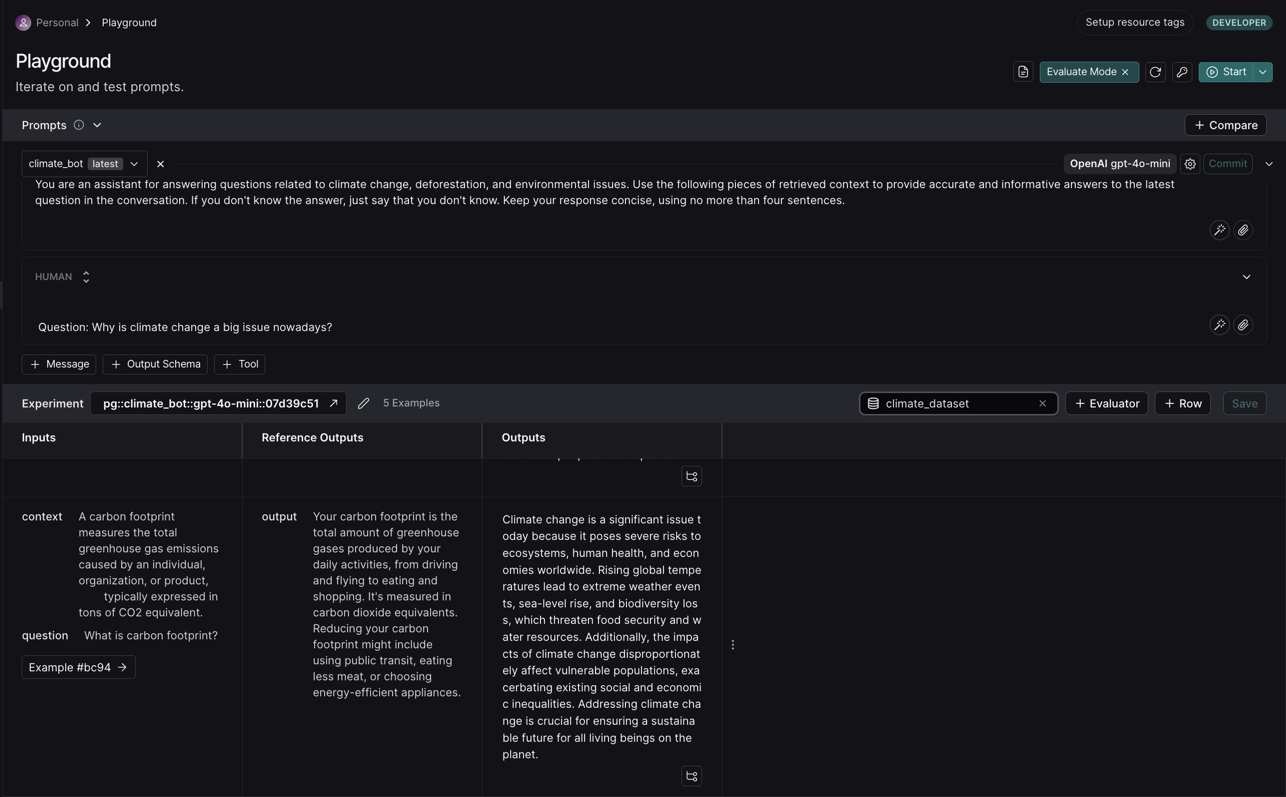